In [166]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from cv2 import normalize, NORM_MINMAX, CV_32F
from src.helpers import plot_accuracy_loss, ploting_images

import pandas as pd
import numpy as np
import seaborn as sns
import random
import PIL
import os
import zipfile

In [74]:
#-----------------------------------------------------
# Basic plot configuration
#-----------------------------------------------------
plt.rcParams['legend.title_fontsize'] = 'x-large'
plt.rcParams['legend.fontsize'] = 'x-large'
plt.rcParams['figure.figsize'] = (15,15)
sns.set_theme(style="whitegrid")

In [3]:
#-----------------------------------------------------
# Load the data:
#-----------------------------------------------------
tmp_zipfile = '/tmp/cats_and_dogs_filtered.zip'
input_path = '../input/'
zip_ref = zipfile.ZipFile(tmp_zipfile)
zip_ref.extractall(input_path)
zip_ref.close()

In [4]:
base_dir = '../input/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

#-----------------------------------------------------
# Training data directory
#-----------------------------------------------------
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

#-----------------------------------------------------
# Validation data directory
#-----------------------------------------------------
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [101]:
#-----------------------------------------------------
# List the filenames in the training directory
#-----------------------------------------------------
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

#-----------------------------------------------------
# Join the filenames with dirnames
#-----------------------------------------------------
cats_img_files = [os.path.join(train_cats_dir, f) for f in train_cats_fnames]
dogs_img_files = [os.path.join(train_dogs_dir, f) for f in train_dogs_fnames]

print("#-----------------------------------------------------")
print(f"5 first filenames in {train_cats_dir}: {train_cats_fnames[:5]}")
print(f"5 first filenames in {train_dogs_dir}: {train_dogs_fnames[:5]}")

#-----------------------------------------------------
# Total number of training images
#-----------------------------------------------------
print("#-----------------------------------------------------")
print(f"Total training images in {train_cats_dir}: {len(train_cats_fnames)}")
print(f"Total training images in {train_dogs_dir}: {len(train_dogs_fnames)}")

#-----------------------------------------------------
5 first filenames in ../input/cats_and_dogs_filtered/train/cats: ['cat.2.jpg', 'cat.615.jpg', 'cat.424.jpg', 'cat.977.jpg', 'cat.8.jpg']
5 first filenames in ../input/cats_and_dogs_filtered/train/dogs: ['dog.779.jpg', 'dog.139.jpg', 'dog.620.jpg', 'dog.646.jpg', 'dog.486.jpg']
#-----------------------------------------------------
Total training images in ../input/cats_and_dogs_filtered/train/cats: 1000
Total training images in ../input/cats_and_dogs_filtered/train/dogs: 1000


In [6]:
#-----------------------------------------------------
# Store sizes
#-----------------------------------------------------
sizes = []
for img in train_cats_fnames:
    img = PIL.Image.open(f"{train_cats_dir}/{img}")
    sizes.append(img.size)

for img in train_dogs_fnames:
    img = PIL.Image.open(f"{train_dogs_dir}/{img}")
    sizes.append(img.size)

df = pd.DataFrame({'Image':train_cats_fnames+train_dogs_fnames, 'Size':sizes})

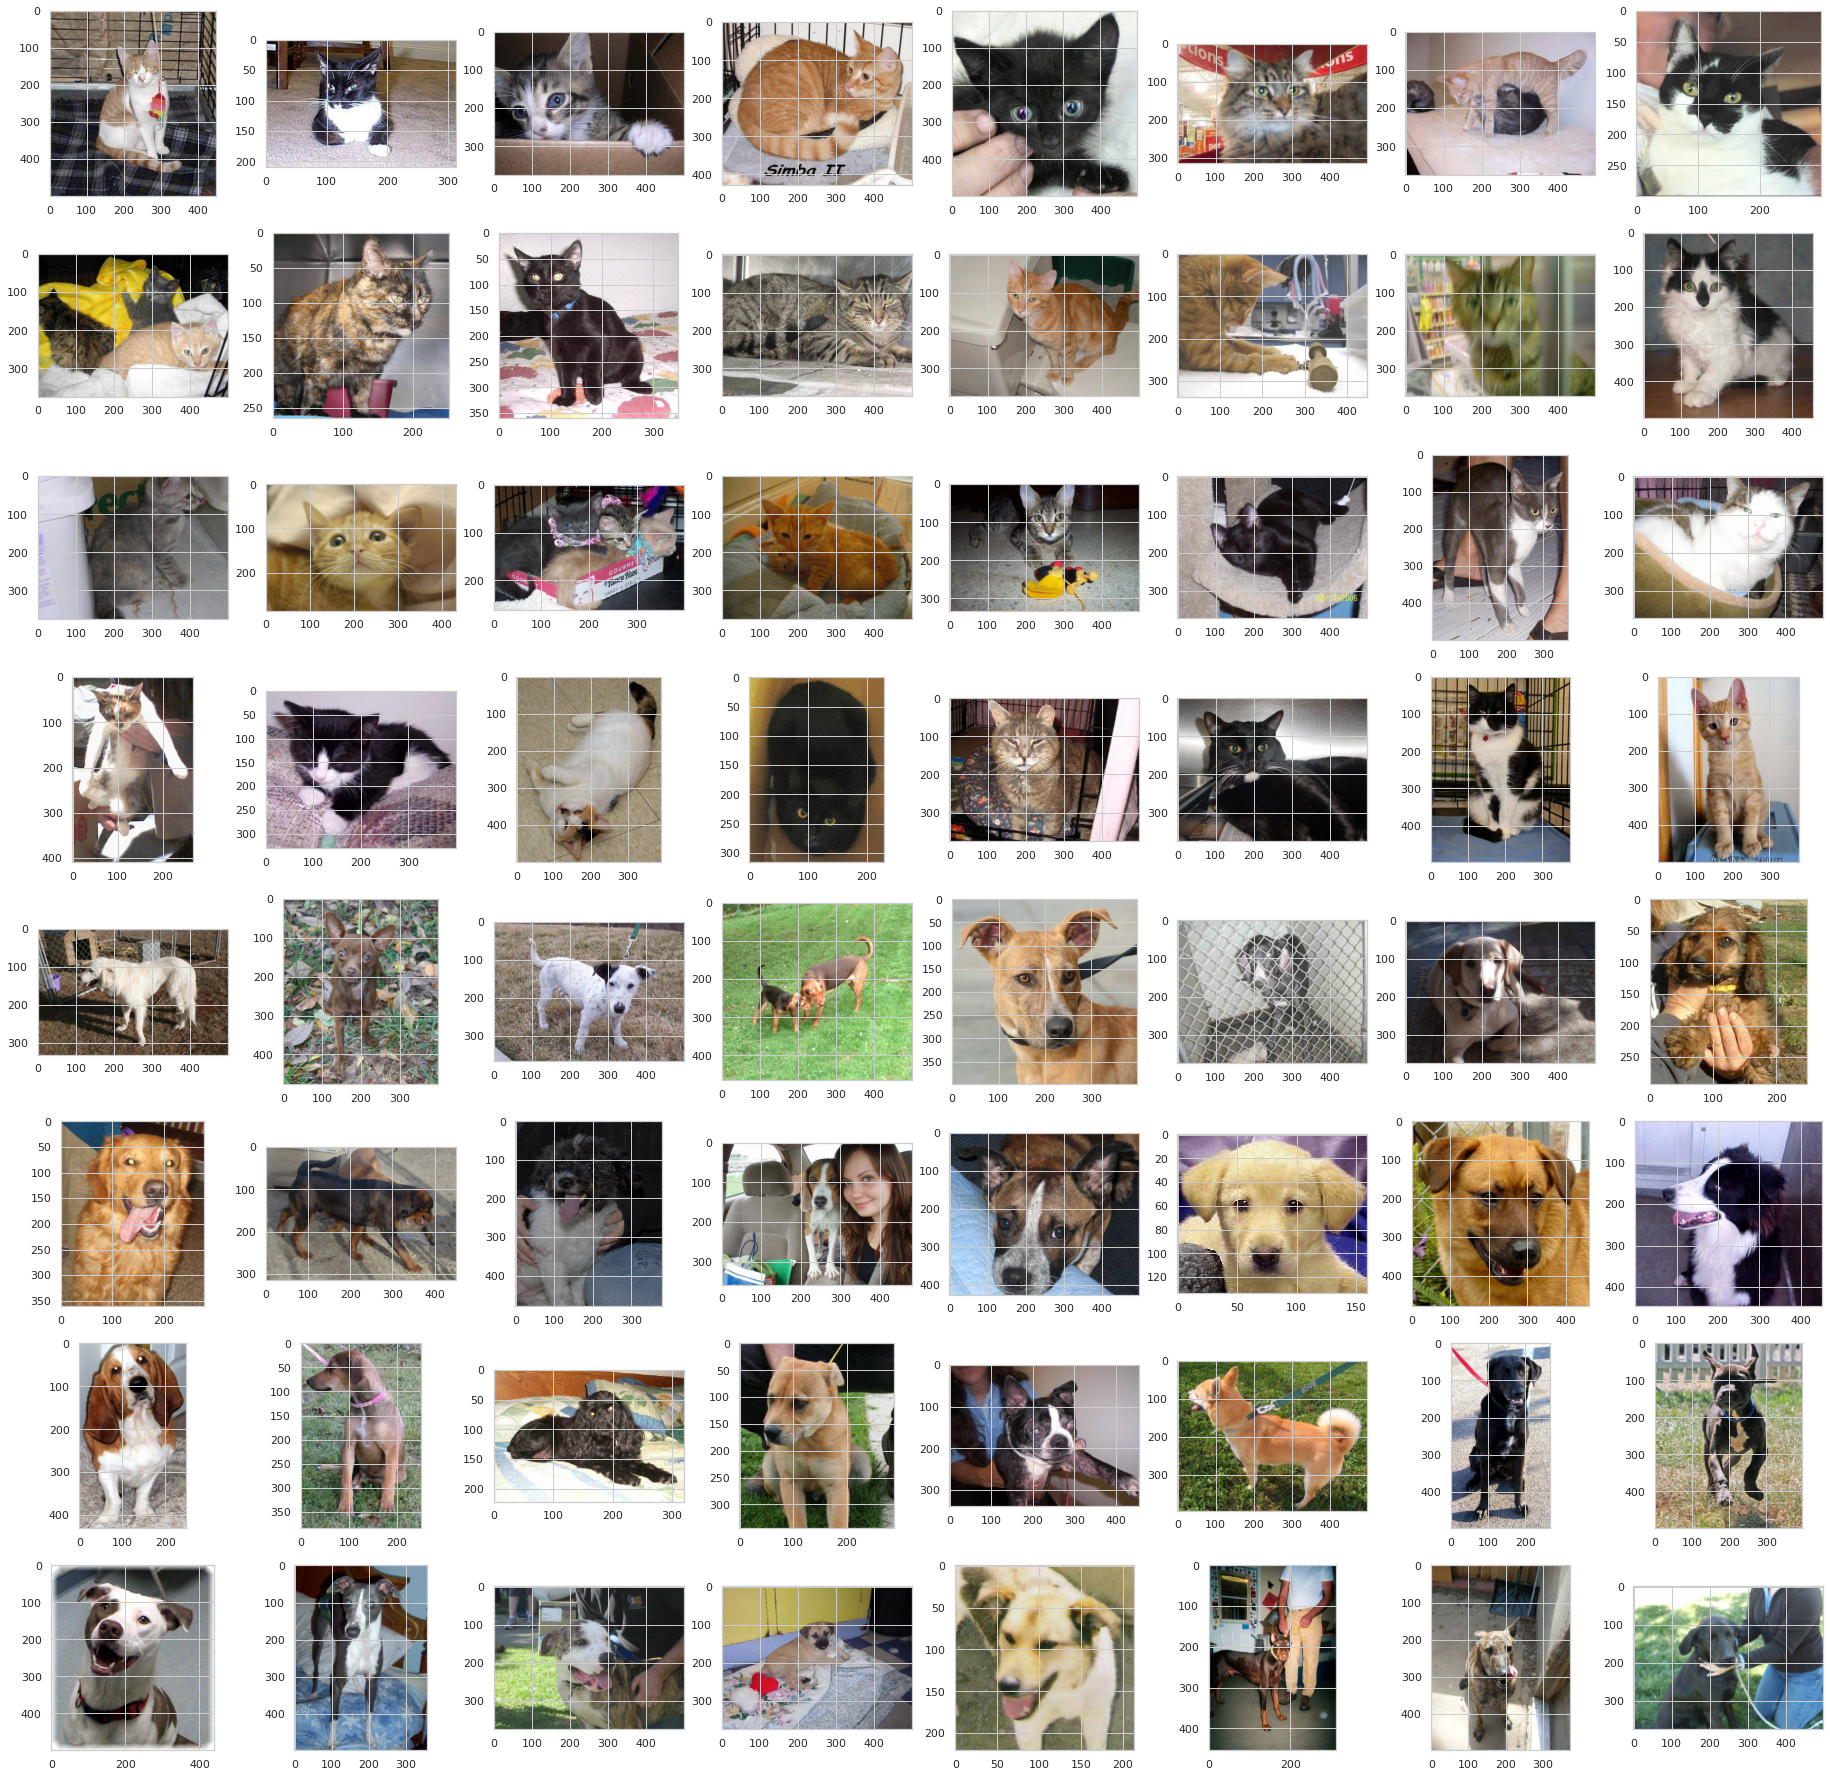

In [8]:
ploting_images([train_cats_dir, train_dogs_dir], 8, 8)

In [9]:
#-----------------------------------------------------
# Data preprocessing: Rescale them to 150x150
#-----------------------------------------------------

train_datagen = ImageDataGenerator(rescale=1./255.)
validation_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=20,
                                                   class_mode='binary',
                                                   target_size=(150, 150))

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                             batch_size=20,
                                                             class_mode='binary',
                                                             target_size=(150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Train the model without **regularization**

In [10]:
#-----------------------------------------------------
# Building the model with no regularization
#-----------------------------------------------------

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [11]:
history = model.fit(train_generator,
         validation_data=validation_generator,
         steps_per_epoch=100,
         epochs=15,
         validation_steps=50,
         verbose=1)

Epoch 1/15
100/100 [==============================] - 20s 191ms/step - loss: 0.8105 - accuracy: 0.5310 - val_loss: 0.6681 - val_accuracy: 0.5880
Epoch 2/15
100/100 [==============================] - 19s 188ms/step - loss: 0.6351 - accuracy: 0.6228 - val_loss: 0.6186 - val_accuracy: 0.6610
Epoch 3/15
100/100 [==============================] - 20s 199ms/step - loss: 0.6003 - accuracy: 0.6903 - val_loss: 0.5932 - val_accuracy: 0.6620
Epoch 4/15
100/100 [==============================] - 20s 198ms/step - loss: 0.5146 - accuracy: 0.7589 - val_loss: 0.5773 - val_accuracy: 0.6800
Epoch 5/15
100/100 [==============================] - 20s 197ms/step - loss: 0.4275 - accuracy: 0.8088 - val_loss: 0.6194 - val_accuracy: 0.6980
Epoch 6/15
100/100 [==============================] - 20s 197ms/step - loss: 0.3443 - accuracy: 0.8324 - val_loss: 0.6750 - val_accuracy: 0.7110
Epoch 7/15
100/100 [==============================] - 20s 196ms/step - loss: 0.2894 - accuracy: 0.8691 - val_loss: 0.6709 - val_ac

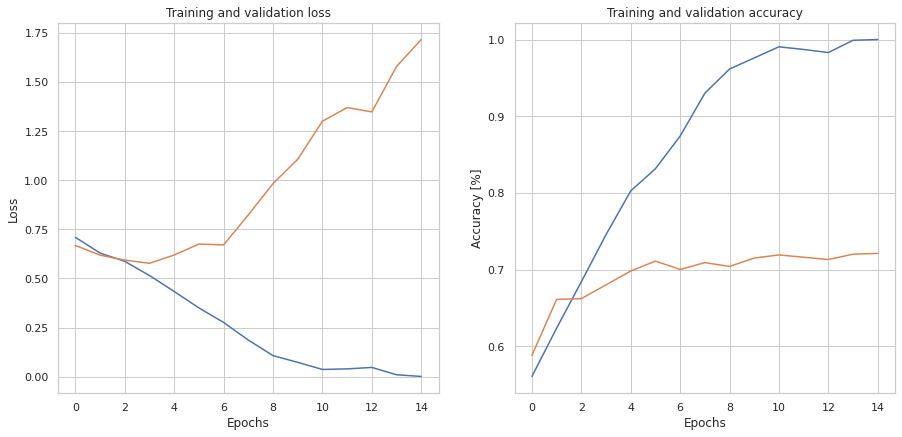

In [82]:
plot_accuracy_loss(history)

The loss on the training set is going down whereas going up on validation set, which indicates overfitting.

### Visualizing the learned **features**

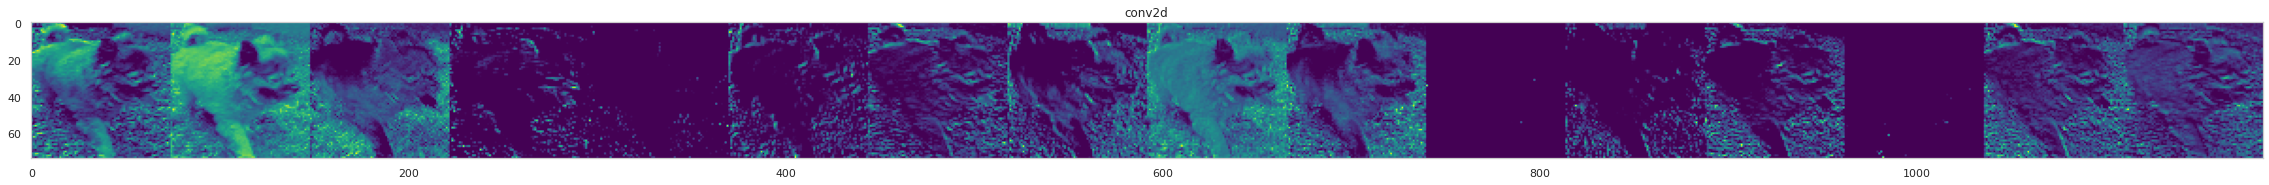

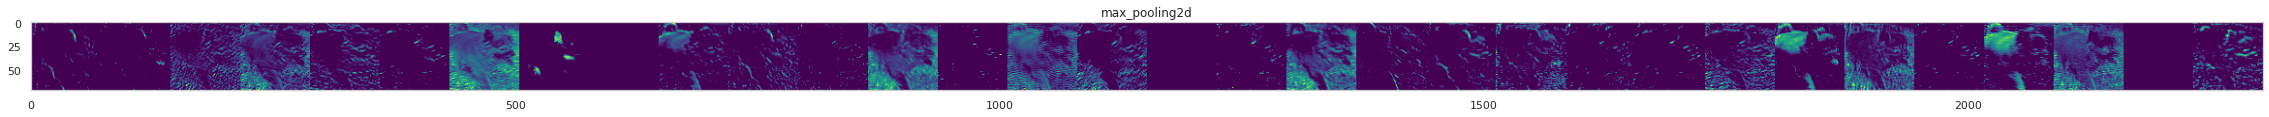

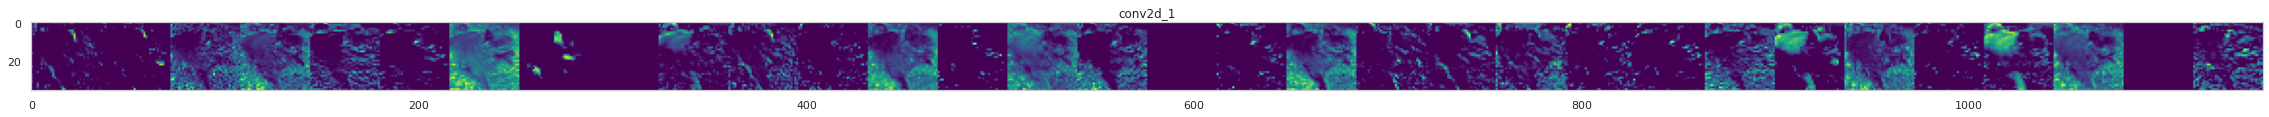

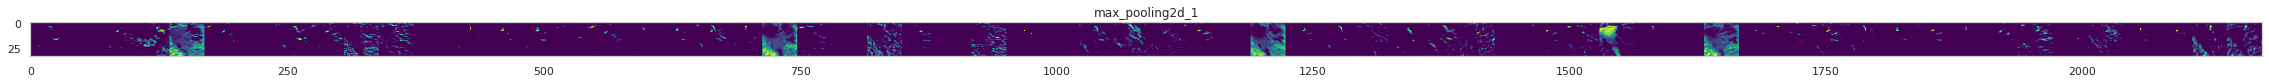

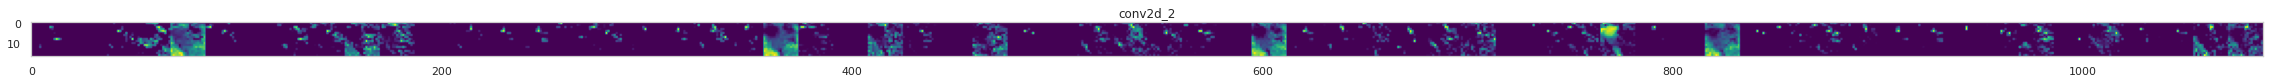

In [178]:
visualize_features_output(model, [cats_img_files, dogs_img_files])

### Applying **regularization**

In [93]:
reg_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D(2,2),
    Dropout(0.3),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.3),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

reg_model.summary()
reg_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)      

In [94]:
history_reg = reg_model.fit(train_generator,
         validation_data=validation_generator,
         steps_per_epoch=100,
         epochs=15,
         validation_steps=50,
         verbose=1)

Epoch 1/15
100/100 [==============================] - 48s 472ms/step - loss: 1.1815 - accuracy: 0.5200 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/15
100/100 [==============================] - 48s 476ms/step - loss: 0.6930 - accuracy: 0.5117 - val_loss: 0.6891 - val_accuracy: 0.5490
Epoch 3/15
  9/100 [=>............................] - ETA: 37s - loss: 0.6773 - accuracy: 0.6070

KeyboardInterrupt: 